(shapely)=
# Geometries (`shapely`)

In [1]:
!echo Last updated: `date +"%Y-%m-%d %H:%M:%S"`

Last updated: 2022-05-29 21:42:55


*****

## Introduction

In the previous chapters we covered the basics of working with Python, starting with the working environment setup (see {ref}`setup`) to advanced methods of working with tables ({ref}`pandas2`). Now, we move on to the main topic of this book, working with *spatial data*. 

Spatial data can be divided into two categories:

* Vector layers—points, lines, and polygons, associated with attributes
* Rasters—numeric arrays representing a regular grid over a rectangular area

In the next three chapters, we go through the basics of working with the first type, *vector layers*, in Python. In this chapter, we cover the `shapely` package, which is used to represent and work with individual vector geometries. The next two chapters (see {ref}`geopandas1` and {ref}`geopandas2`) deal with another package, called `geopandas`, which is used to represent an work with vector layers. The individual geometries *within* a vector layer are stored as `shapely` geometries. Therefore it is essential to be familiar with the `shapely` package, first, before moving on `geopandas`.

Specifically, in this chapter we are going to cover the following topics:

* Several methods of creating geometry objects (see {ref}`shapely-creating-geometries`)
* Extracting geometry properties, such as:
    * Geometry type (see {ref}`shapely-geometry-type`)
    * Coordinates (see {ref}`shapely-coordinates`)
    * Derived properties, such as length and area (see {ref}`shapely-derived-properties`)
* Creating new geometries, from:
    * Individual geometries (see {ref}`shapely-new-geometries-1`), e.g., calculating geometry centroid
    * Pairs of geometries (see {ref}`shapely-new-geometries-2`), e.g., calculating the intersection (i.e., shared area) of two geometries
* Evaluating boolean relations between geometries (see {ref}`shapely-boolean-functions`), e.g., whether one geometry intersects with another or not
* Calculating distances (see {ref}`shapely-distance`)
* Transforming points to a line (see {ref}`shapely-geometry-casting`)

## What is `shapely`?

`shapely` is a Python package for working with vector geometries, that is, the geometric component of vector layers (the other component being non-spatial attributes). `shapely` includes functions for creating geometries, as well as functions for applying geometric operations on geometries, such as calculating the centroid of a polygon.

Technically, `shapely` is a Python interface to the [Geometry Engine Open Source (GEOS)](https://trac.osgeo.org/geos) software. GEOS is used in numerous open-source programs other than `shapely`, such as [QGIS](https://www.qgis.org/en/site/), and interfaced in many programming languages, such as the [`sf`](https://r-spatial.github.io/sf/) package in R.

By design, `shapely` only deals with individual geometries, their creation, their derived properties, and spatial operation applied to them. `shapely` does not include any functions to read or write geometries to or from files, or more complex data structures to represent collections of geometries with or without non-spatial attributes (i.e., vector layers). These are accomlished with `geopandas`, which builds on top of `pandas` and `shapely` ({numref}`python-package-deps`), to provide more high-level methods to work with complete vector layers. 

```{note}
The `shapely` [documentation](https://shapely.readthedocs.io/en/stable/manual.html) ({numref}`shapely-manual`) is quite detailed, and has many illustrations which are useful to understand how the various functions work.
```

```{figure} images/shapely_manual.png
---
name: shapely-manual
---
[The Shapely User Manual](https://shapely.readthedocs.io/en/stable/manual.html)
```

(what-are-simple-features)=
## What are Simple Features?

The GEOS software, and accordingly also the `shapely` package, implements the [Simple Features](https://en.wikipedia.org/wiki/Simple_Features) specification of geometry types. The geometry type [specification](https://www.ogc.org/standards/sfa) and functions may be familiar to you, since both the GEOS software and the Simple Features standard are widely used in open-source GIS software and in other programming languages, such as R's `sf` package and the PostGIS spatial database. 

The Simple Features defines at least [17 geometry types](https://r-spatial.github.io/sf/articles/sf1.html#simple-feature-geometry-types), but only seven types are commonly used in spatial analysis. These are 
shown in {numref}`feature-types`. Note that there are separate geometry types for points (`"Point"`), lines (`"LineString"`), and polygons (`"Polygon"`), as well are their multi-part versions (`"MultiPoint"`, `"MultiLineString"`, `"MultiPolygon"`), which sums up to the first six geometry types. The multi-part versions are intended for geometries that contain more than one single-part geometry at once. The seventh type (`"GeometryCollection"`) is intended for any combination of the other six types.

```{figure} images/simple_feature_types.svg
---
name: feature-types
---
Simple Feature geometry types
```

[Well Known Text (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) is a plain text format for representing Simple Feature geometries, and part of the Simple Feature standard. WKT is understood by many programs, including `shapely`, the `sf` package in R, and PostGIS. WKT strings of the geometries shown in {numref}`feature-types` are given in {numref}`geometry-types-wkt-examples` [^wkt-examples].

[^wkt-examples]: WKT examples are from Wikipedia (<https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry>).

```{table} Simple feature geometry types and WKT examples
:name: geometry-types-wkt-examples

| Type | WKT example |
|---|---|
| `"Point"` | `POINT (30 10)` |
| `"LineString"` | `LINESTRING (30 10, 10 30, 40 40)` |
| `"Polygon"` | `POLYGON ((35 10, 45 45, 15 40, 10 20, 35 10),(20 30, 35 35, 30 20, 20 30))` |
| `"MultiPoint"` | `MULTIPOINT (10 40, 40 30, 20 20, 30 10)` |
| `"MultiLineString"` | `MULTILINESTRING ((10 10, 20 20, 10 40),(40 40, 30 30, 40 20, 30 10))`|
| `"MultiPolygon"` | `MULTIPOLYGON (((40 40, 20 45, 45 30, 40 40)),((20 35, 10 30, 10 10, 30 5, 45 20, 20 35),(30 20, 20 15, 20 25, 30 20)))`|
| `"GeometryCollection"` | `GEOMETRYCOLLECTION (POINT (40 10),LINESTRING (10 10, 20 20, 10 40),POLYGON ((40 40, 20 45, 45 30, 40 40)))`|
```

Do not worry if you are not familiar with the exact syntax of the WKT format. You will have an opportunity to see various WKT strings in the examples in this chapter. For now, just note that these are strings specifying the geometry type and the coordinates comprising the geometry. Parentheses (`(`) are used the indicate the nested structure of coordinate sequences withing the geometry, such as the separate polygons comprising a `"MultiPolygon"` geometry, or the exterior and interior (i.e., holes) in a `"Polygon"`. For example:

* `POINT (30 10)`—A *point* at $(30,10)$
* `LINESTRING (0 0, 0 1)`—A straight *line* going from $(0,0)$ to $(0,1)$

(shapely-creating-geometries)=
## Creating geometries

(shapely-from-wkt)=
### `shapely` from WKT

Before starting to work with `shapely`, we need to load the package. The `shapely` package is organized into sub-packages, of which we need two. Specifically, we load the sub-package `shapely.geometry` which contains all geometry-related functions we will be working with. We also load the `shapely.wkt` sub-package, which is necessary to convert Well Known Text (WKT) strings to `shapely` geometries:

In [2]:
import shapely.geometry
import shapely.wkt

One way to create a `shapely` geometry object is to import a WKT string. To convert a WKT string into a `shapely` geometry, we pass the WKT string to the [`shapely.wkt.loads`](https://shapely.readthedocs.io/en/stable/manual.html#shapely.wkt.loads) function (short for "load string"). In our first example, we create a polygon named `pol1`. Note that this is a rectange, composed of five coordinates. The fifth coordinate is identical to the first, used to "close" the shape, as required by the WKT syntax:

In [3]:
pol1 = shapely.wkt.loads("POLYGON ((0 0, 0 -1, 7.5 -1, 7.5 0, 0 0))")

Typing a `shapely` geometry in a Jupyter notebook conveniently draws a small figure:

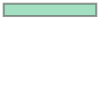

In [4]:
pol1

We can also `print` the geometry, which prints its WKT string representation:

In [5]:
print(pol1)

POLYGON ((0 0, 0 -1, 7.5 -1, 7.5 0, 0 0))


The `type` of a `shapely` geometry consists of several components, starting from the general class, `shapely.geometry`, and ending with the specific geometry type, such as `"Polygon"`: 

In [6]:
type(pol1)

shapely.geometry.polygon.Polygon

Let us create another polygon geometry, named `pol2`:

In [7]:
pol2 = shapely.wkt.loads("POLYGON ((0 1, 1 0, 2 0.5, 3 0, 4 0, 5 0.5, 6 -0.5, 7 -0.5, 7 1, 0 1))")
print(pol2)

POLYGON ((0 1, 1 0, 2 0.5, 3 0, 4 0, 5 0.5, 6 -0.5, 7 -0.5, 7 1, 0 1))


This time we have more coordinates, and, accordingly, the shape of the polygon is more complex:

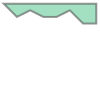

In [8]:
pol2

Finally, let us create another type of geometry, a `"MultiPolygon"`, named `pol3`. Note how the `"MultiPolygon"` has several sequences of shapes, representing the outline and hole(s) of one or more polygons:

In [9]:
pol3 = shapely.wkt.loads("""
MULTIPOLYGON
(((40 40, 20 45, 45 30, 40 40)),
((20 35, 10 30, 10 10, 30 5, 45 20, 20 35), (30 20, 20 15, 20 25, 30 20)))
""")

```{note}
The above expression uses multi-line string input in Python, using the `"""` character at the start and end of the string. This tells the Python interpreter that the string spans several lines. Otherwise we would get an error since a "newline" character ends the expression.
```

In `pol3`, we have one polygon without any holes, and another polygon that has one hole:

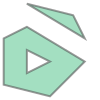

In [10]:
pol3

```{admonition} Exercise 07-a
:class: important
* Go to the WKT [article](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) on Wikipedia.
* Locate examples of other types of geometries, such as `"Point"`, `"LineString"`, `"MultiPoint"`, and `"MultiLineString"`. Create the corresponding `shapely` geometries.
* Print the shapes to inspect them graphically. Compare to the figures on Wikipedia.
```

(shapely-create-specific-functions)=
### `shapely` from type-specific functions

Another method of creating `shapely` geometries is to pass lists of coordinates to specific functions, according to the required geometry type ({numref}`shapely-functions-to-create-geometry`).


```{table} <code>shapely</code> functions to create geometries
:name: shapely-functions-to-create-geometry

| Function | Geometry type |
|---|---|
| [`shapely.geometry.Point`](https://shapely.readthedocs.io/en/stable/manual.html#Point) | `"Point"` |
| [`shapely.geometry.MultiPoint`](https://shapely.readthedocs.io/en/stable/manual.html#MultiPoint) | `"MultiPoint"` |
| [`shapely.geometry.LineString`](https://shapely.readthedocs.io/en/stable/manual.html#LineString) | `"LineString"` |
| [`shapely.geometry.MultiLineString`](https://shapely.readthedocs.io/en/stable/manual.html#MultiLineString) | `"MultiLineString"` |
| [`shapely.geometry.Polygon`](https://shapely.readthedocs.io/en/stable/manual.html#Polygon) | `"Polygon"` |
| [`shapely.geometry.MultiPolygon`](https://shapely.readthedocs.io/en/stable/manual.html#MultiPolygon) | `"MultiPolygon"` |
| [`shapely.geometry.GeometryCollection`](https://shapely.readthedocs.io/en/stable/manual.html#collections) | `"GeometryCollection"` |
```

Each of the function takes input of a different form, according to the geometry type. For example, to create a `"Point"` geometry, we need to pass a `tuple` of the form `(x,y)` to [`shapely.geometry.Point`](https://shapely.readthedocs.io/en/stable/manual.html#points):

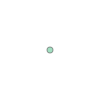

In [11]:
pnt1 = shapely.geometry.Point((2, 0.5))
pnt1

A `"MultiPoint"`, however, can be created from a `list` of `tuple`s, where each list elements represents an individual point, using [`shapely.geometry.MultiPoint`](https://shapely.readthedocs.io/en/stable/manual.html#collections-of-points):

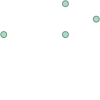

In [12]:
coords = [(2, 0.5), (1, 1), (-1, 0), (1, 0)]
pnt2 = shapely.geometry.MultiPoint(coords)
pnt2

A `"LineString"` is also created from a `list` of `tuple`s, using [`shapely.geometry.LineString`](https://shapely.readthedocs.io/en/stable/manual.html#linestrings):

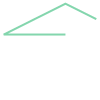

In [13]:
coords = [(2, 0.5), (1, 1), (-1, 0), (1, 0)]
line1 = shapely.geometry.LineString(coords)
line1

A `"MultiLineString"` can be created from a `list` of `"LineString"` geometries, using [`shapely.geometry.MultiLineString`](https://shapely.readthedocs.io/en/stable/manual.html#collections-of-lines):

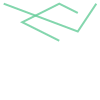

In [14]:
l1 = shapely.geometry.LineString([(2, 0.5), (1, 1), (-1, 0), (1, -1)])
l2 = shapely.geometry.LineString([(-2, 1), (2, -0.5), (3, 1)])
line2 = shapely.geometry.MultiLineString([l1, l2])
line2

```{admonition} Exercise 07-b
:class: important
* The `shapely.geometry.GeometryCollection` function accepts a `list` of geometries, and returns a `"GeometryCollection"` composed of them. 
* Use the above objects to construct and plot a `"GeometryCollection"` that contains a point, a line, and a polygon.
```

A `"Polygon"` can be created using the [`shapely.geometry.Polygon`](https://shapely.readthedocs.io/en/stable/manual.html#polygons) function and using a coordinate sequence where the first and last points are identical:

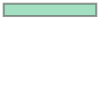

In [15]:
coords = [(0, 0), (0, -1), (7.5, -1), [7.5, 0], (0, 0)]
shapely.geometry.Polygon(coords)

Optionally, a second `list` may used to pass a `list` of sequences comprising polygon holes. For example, the following modified expressions create a polygon with one hole: 

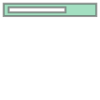

In [16]:
coords_exterior = [(0, 0), (0, -1), (7.5, -1), [7.5, 0], (0, 0)]
coords_interiors = [[(0.4, -0.3), (5, -0.3), (5, -0.7), (0.4, -0.7), (0.4, -0.7)]]
shapely.geometry.Polygon(coords_exterior, coords_interiors)

A `"MultiPolygon"` can be created from a `list` of individual `"Polygon"` geometries, using [`shapely.geometry.MultiPolygon`](https://shapely.readthedocs.io/en/stable/manual.html#collections-of-polygons):

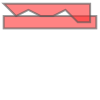

In [17]:
shapely.geometry.MultiPolygon([pol1, pol2])

Note that what we got in the last expression is an individual `"MultiPolygon"` geometry, *not* two separate polygon geometries:

In [18]:
print(shapely.geometry.MultiPolygon([pol1, pol2]))

MULTIPOLYGON (((0 0, 0 -1, 7.5 -1, 7.5 0, 0 0)), ((0 1, 1 0, 2 0.5, 3 0, 4 0, 5 0.5, 6 -0.5, 7 -0.5, 7 1, 0 1)))


```{note}
The above `"MultiPolygon"` geometry is considered *invalid*, i.e., not in agreement with the Simple Features specification (see {ref}`what-are-simple-features`). Validity can be examined using the [`.is_valid`](https://shapely.readthedocs.io/en/stable/manual.html#object.is_valid) property. It is also suggested by the green/red color of the geometry visualization. Specifically, a valid `"MultiPolygon"` geometry cannot overlap in an infinite number of points.
```

### `shapely` from `shape`

Our third method to create `shapely` geometries is the [`shapely.geometry.shape`](https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.shape) function. This function accepts a [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON)-like `dict` with the geometry definition. In general, the `dict` needs to have two properties: 

* The `"type"` property contains the geometry type
* The `"coordinates"` property contains the sequences of geometries/parts/coordinates, as `list`s or `tuple`s

For example, the following expression uses `shapely.geometry.shape` to create a `"Point"` geometry:

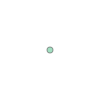

In [19]:
d = {"type": "Point", "coordinates": (0, 1)}
shapely.geometry.shape(d)

The following expression uses `shapely.geometry.shape` to create a `"MultiPolygon"` geometry. Accordingly, the input `dict` is more complex:

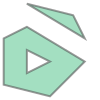

In [20]:
d = {
  "type": "MultiPolygon",
  "coordinates": [
    [
      [[40, 40], [20, 45], [45, 30], [40, 40]]
    ],
    [
      [[20, 35], [10, 30], [10, 10], [30, 5], [45, 20], 
      [20, 35]], 
      [[30, 20], [20, 15], [20, 25], [30, 20]]
    ]
  ]
}
shapely.geometry.shape(d)

(shapely-geometry-type)=
## Geometry type

As demonstrated above, the information contained in a `shapely` geometry is basically composed of two items:

* The geometry type, such as `"Point"`
* The coordinate sequence(s) of all shapes comprising the geometry, such as `(0,1)`

Using `shapely` methods, we can access the two items. In this section we show how to access geometry type, which is simple enough. In the next section, we discuss the methods to access the coordinates, which is more complex (see {ref}`shapely-coordinates`).

The [`.geom_type`](https://shapely.readthedocs.io/en/stable/manual.html#object.geom_type) property of a `shapely` geometry contains the geometry type:

In [21]:
pol1.geom_type

'Polygon'

This is a string:

In [22]:
type(pol1.geom_type)

str

(shapely-coordinates)=
## Geometry coordinates

### Overview

The other component of a shape (in addition to type, see {ref}`shapely-geometry-type`) is the shape coordinates. In the following sub-sections, we demonstrate the ways we can access the coordinates of the five most commonly used geometry types ({numref}`shapely-accessing-coords`).

```{table} Accessing <code>shapely</code> geometry coordinates
:name: shapely-accessing-coords

| Geometry type | Access method |
|---|---|
| {ref}`point-coordinates` | `.coords` |
| {ref}`linestring-coordinates` | `.coords` |
| {ref}`multilinestring-coordinates` | `.geoms[0].coords` |
| {ref}`polygon-coordinates` | `.exterior.coords`, `.interiors[0].coords` |
| {ref}`multipolygon-coordinates` | `.geoms[0].exterior.coords`, `.geoms[0].interiors[0].coords` |
```

As we will see, the access method is specific per geometry types, due to their different levels of complexity.

In practice, it is rarely necessary to access the coordinates *directly*, because there are predefined functions for all common operations involving the coordinates (such as calculating the centroid, see {ref}`shapely-centroid`). However, being aware of the coordinate access methods gives you the freedom, *if necessary*, to develop any type of geometric calculation or algorithm, even if it is not defined in `shapely`, or any other software. Additionally, through the access methods we will become more familiar with the structure and differences between the geometry types.

(point-coordinates)=
### `Point` coordinates

`"Point"` geometry coordiantes are accessible thought the `.coords` property. The returned object is of a special type called [`CoordinateSequence`](https://shapely.readthedocs.io/en/stable/manual.html#coordinate-sequences):

In [23]:
pnt1.coords

It can be converted to a more convenient form, of a `list`, using the `list` function:

In [24]:
list(pnt1.coords)

[(2.0, 0.5)]

As we can see, coordinates are organized as a `list` of `tuple`s. In this case, since with are talking about a `Point` geometry, the `list` is of length 1, containing a `tuple` of the point coordinates.

(linestring-coordinates)=
### `LineString` coordinates

The coordinates of a `"LineString"` are accessible in exactly the same way as those of `"Point"` (see {ref}`point-coordinates`).

In [25]:
list(line1.coords)

[(2.0, 0.5), (1.0, 1.0), (-1.0, 0.0), (1.0, 0.0)]

However, the list is not of length 1, but at least of length 2. For `line1`, the list is of lenght 4, because the line is composed of four points.

(multilinestring-coordinates)=
### `MultiLineString` coordinates

For `"MultiLineString"` geometries, there is no direct `.coords` method to access the coordinates of all parts at once. Instead, the parts have to be accessed one by one, using the `.geoms` property, combined with an index (starting from `0`). Any particular "part" of a `"MultiLineString"` geometry behaves the same way as a `"LineString"` geometry. Once we are "inside" a particular `"MultiLineString"` part, we can use any of the properties or methods applicable to a `"LineString"` geometry, such as `coords`.

For example, here is how we can access the two parts of the `"MultiLineString"` named `line2`:

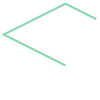

In [26]:
line2.geoms[0]

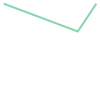

In [27]:
line2.geoms[1]

Note that each part of a `"MultiLineString"` is a `"LineString"`:

In [28]:
type(line2.geoms[0])

shapely.geometry.linestring.LineString

In case we do not know in advance how many parts there are, we can use the `len` function to find out:

In [29]:
len(line2.geoms)

2

Going further, we can access the coordinates of each part using `.coords` (see {ref}`linestring-coordinates`):

In [30]:
list(line2.geoms[0].coords)

[(2.0, 0.5), (1.0, 1.0), (-1.0, 0.0), (1.0, -1.0)]

In [31]:
list(line2.geoms[1].coords)

[(-2.0, 1.0), (2.0, -0.5), (3.0, 1.0)]

(polygon-coordinates)=
### `Polygon` coordinates

`"Polygon"` coordinate sequences are associated with the concepts of *exterior* and *interiors* coordinate sequences: 

* The **exterior** is the outer bound of the polygon. There is only one exterior sequence per polygon. The `.exterior` property gives direct access to the exterior geometry.
* The **interiors** refers to polygon *holes*. There can be zero or more holes in each polygon. Accordingly, the `.interiors` property is a sequence of length zero or more. 

For example, `pol1` is a `"Polygon"` with no holes. We can access the exterior coordinates using `.exterior`, and then `.coords`:

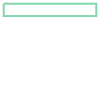

In [32]:
pol1.exterior

In [33]:
list(pol1.exterior.coords)

[(0.0, 0.0), (0.0, -1.0), (7.5, -1.0), (7.5, 0.0), (0.0, 0.0)]

However, the `.interiors` sequence is empty:

In [34]:
len(pol1.interiors)

0

You will get a chance to see a non-empty `.interiors` sequence in the next example (see {ref}`multipolygon-coordinates`).

(multipolygon-coordinates)=
### `MultiPolygon` coordinates

`"MultiPolygon"` coordinates are accessed by first extracting one of the polygon part, using `.geoms`, similarly to the way we extract `"MultiLineString"` parts (see {ref}`multilinestring-coordinates`). Each of the `"MultiPolygon"` parts is a `"Polygon"` geometry. Therefore, we can use the `exterior` and `interiors` methods to get the coordinates of each part, just like with a standalone `"Polygon"` (see {ref}`polygon-coordinates`).

For example, `pol3` is a `"MultiPolygon"` geometry with two parts, whereas one of the parts has one hole:

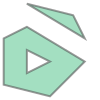

In [35]:
pol3

The `.geoms` method lets us access the parts one by one:

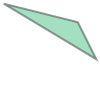

In [36]:
pol3.geoms[0]

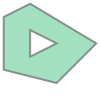

In [37]:
pol3.geoms[1]

Note that each part of a `"MultiPolygon"` geometry is a `"Polygon"` geometry:

In [38]:
type(pol3.geoms[0])

shapely.geometry.polygon.Polygon

Starting with the first part, here is the exterior:

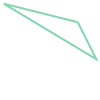

In [39]:
pol3.geoms[0].exterior

In [40]:
list(pol3.geoms[0].exterior.coords)

[(40.0, 40.0), (20.0, 45.0), (45.0, 30.0), (40.0, 40.0)]

As expected, there are no interiors:

In [41]:
len(pol3.geoms[0].interiors)

0

Now, here is the second part of the `"MultiPolygon"`:

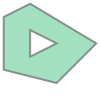

In [42]:
pol3.geoms[1]

Here is the exterior:

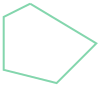

In [43]:
pol3.geoms[1].exterior

and its coordinates:

In [44]:
list(pol3.geoms[1].exterior.coords)

[(20.0, 35.0),
 (10.0, 30.0),
 (10.0, 10.0),
 (30.0, 5.0),
 (45.0, 20.0),
 (20.0, 35.0)]

This part *does* contain interiors, specifically one "interior" (i.e., hole):

In [45]:
len(pol3.geoms[1].interiors)

1

Here is how we can access the interior:

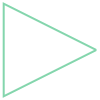

In [46]:
pol3.geoms[1].interiors[0]

and its coordinates:

In [47]:
list(pol3.geoms[1].interiors[0].coords)

[(30.0, 20.0), (20.0, 15.0), (20.0, 25.0), (30.0, 20.0)]

(shapely-derived-properties)=
## Derived properties

### Overview

The geometry type ({ref}`shapely-geometry-type`), and the geometry coordinates along with their division to parts and interior/exterior sequences ({ref}`shapely-coordinates`), are basic "internal" geometry properties. Additionally, there are *derived* useful properties that can be calculated for each geometry. 

In the next few section we cover several useful derived geometry properties, namely:

* `.bounds`—{ref}`shapely-bounding-box`
* `.length`—{ref}`shapely-length`
* `.area`—{ref}`shapely-area`

(shapely-bounding-box)=
### Bounds (`shapely`)

The `.bounds` property of a `shapely` geometry contains its *bounds*, i.e., the coordinates of the bottom-left $(x_{min}, y_{min})$ and top-right $(x_{max}, y_{max})$ corner. The four coordinates are returned in the form of a tuple of length four $(x_{min}, y_{min}, x_{max}, y_{max})$. For example:

In [48]:
pol1.bounds

(0.0, -1.0, 7.5, 0.0)

In [49]:
pol2.bounds

(0.0, -0.5, 7.0, 1.0)

In [50]:
pol3.bounds

(10.0, 5.0, 45.0, 45.0)

Note that even a `"Point"` geometry has bounds, where $x_{min}$ is equal to $x_{max}$, and $y_{min}$ is equal to $y_{max}$:

In [51]:
pnt1.bounds

(2.0, 0.5, 2.0, 0.5)

The [`shapely.geometry.box`](https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.box) function can be used to create a `"Polygon"` geometry reflecting the bounding box. For example, the following expression creates the bounding box geometry of `pol3`:

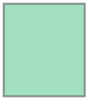

In [52]:
shapely.geometry.box(*pol3.bounds)

Note that the `shapely.geometry.box` function requires four separate positional arguments (i.e., `box(xmin,ymin,xmax,ymax)`), rather than a tuple. Therefore, in the last expression, we used the positional argument technique (see {ref}`positional-arguments`) to "unpack" the `pol3.bounds` tuple into four arguments passed to `box`. The equivalent expression *without* using the positional argument technique would be much longer:

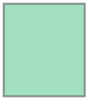

In [53]:
shapely.geometry.box(pol3.bounds[0], pol3.bounds[1], pol3.bounds[2], pol3.bounds[3])

```{note}
The `.envelope` property ({numref}`shapely-new-geoms-individual`) can be used to directly access the bounding box geometry.
```

(shapely-length)=
### Length (`shapely`)

The [`.length`](https://shapely.readthedocs.io/en/stable/manual.html#object.length) property gives the *length* of the geometry. For example, here we calculate the length of `line1`, a `"LineString"` geometry:

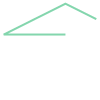

In [54]:
line1

In [55]:
line1.length

5.354101966249685

and here we calculate the length of `line2`, which is a `"MultiLineString"` geometry:

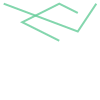

In [56]:
line2

In [57]:
line2.length

11.664947454140234

Note that the length (or area, see {ref}`shapely-area`) of a multi-part geometry is the sum of lengths (or areas) of all its *parts*. For example, using the access methods shown above (see {ref}`shapely-coordinates`), we can calculate the length of the two parts that comprise the `"MultiLineString"` named `line2`:

In [58]:
line2.geoms[0].length

5.5901699437494745

In [59]:
line2.geoms[1].length

6.07477751039076

and demonstrate that the sum of lengths of the two parts is equal to the total geometry length:

In [60]:
line2.geoms[0].length + line2.geoms[1].length == line2.length

True

Keep in mind that:

* The `.length` of `"Point"` or `"MultiPoint"` geometries is equal to `0` 
* The `.length` of `"Polygon"` or `"MultiPolygon"` geometries refers to the summed perimeters of the exterior and all interiors

```{admonition} Exercise 07-c
:class: important
* `pol1` is a `"Polygon"` geometry representing a rectangle in parallel to the x- and y-axes. 
* Calculate the rectangle perimeter "manually" using the formula $(|x_{max} - x_{min}|)*2 + (|y_{max} - y_{min}|)*2$.
* Demonstrate that the result is equal to `pol1.length`.
```

(shapely-area)=
### Area (`shapely`)

The [`.area`](https://shapely.readthedocs.io/en/stable/manual.html#object.area) property gives the area of a given geometry. For example, here is how we can get the areas of `pol1`, `pol2`, and `pol3`:

In [61]:
pol1.area

7.5

In [62]:
pol2.area

6.25

In [63]:
pol3.area

712.5

Keep in mind that the area of `"Point"`, `"MultiPoint"`, `"LineString"`, and `"MultiLineString"` geometries is equal to `0`!

```{admonition} Exercise 07-d
:class: important
* Write expressions to calculate the area of each of the two parts that comprise the `"MultiPolygon"` named `pol3`. 
* Write an expression that demonstrates that the sum of the two areas is equal to `pol3.area` (similarly to what we did for length of `line2`, see {ref}`shapely-length`).
```

(shapely-new-geometries-1)=
## New geometries 1

### Overview

The `shapely` package contains many commonly used methods to create new geometries based on existing ones ({numref}`shapely-new-geoms-individual`). These are defined as properties, or methods, of an existing geometry. In the following sections, we go over three most common ones: `.centroid`, `.buffer()`, and `.convex_hull`.

```{table} <code>shapely</code> functions to create a new geometry from an input individual geometry
:name: shapely-new-geoms-individual

| Method | Meaning |
|---|---|
| `.centroid` | {ref}`shapely-centroid` |
| `.buffer()` | {ref}`shapely-buffer` |
| `.convex_hull` | {ref}`convex-hull` |
| `.envelope` | Bounding box |
| `.minimum_rotated_rectangle` | Minimum rotated rectangle | 
| `.simplify` | Simplified geometry | 
```

(shapely-centroid)=
### Centroids (`shapely`)

The *centroid* is defined as the center of mass of a geometry. The centroid of a given geometry is obtained through the [`.centroid`](https://shapely.readthedocs.io/en/stable/manual.html#object.centroid) property. For example:

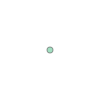

In [64]:
pol2.centroid

To visualize the centroid along with the original geometry, we may take advantage of the `"GeometryCollection"` geometry type, as follows:

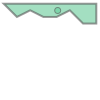

In [65]:
shapely.geometry.GeometryCollection([pol2, pol2.centroid])

(shapely-buffer)=
### Buffer (`shapely`)

A *buffer* is a geometry that encompasses all points within a given distance from the input geometry. In `shapely`, a buffer is calculated using the [`.buffer`](https://shapely.readthedocs.io/en/stable/manual.html#object.buffer) method, given the specified distance. For example, here is a buffer `5` units of distance around `pol1`:

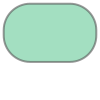

In [66]:
pol1.buffer(5)

Here is another example, `pol2` buffered to a distance of `0.75`:

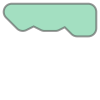

In [67]:
pol2.buffer(0.75)

Keep in mind that `shapely` does not have a notion of Coordinate Reference Systems (CRS). The buffer distance, as well as the distances in any other distance-related calculation, are specified in the same (undefined) units as the geometry coordinates. CRS are defined "on top" of `shapely` geometries in higher-level packages such as `geopandas` (see {ref}`geopandas-crs` and {ref}`geopandas-reprojection`).

Also note that the `.buffer` distance can be negative, in which case the buffer is "internal" rather than "external".

```{admonition} Exercise 07-e
:class: important
* What do you think will happen when we use a negative buffer which is large enough so that the geometry "disappears"? 
* Use the plot and `print` methods to see how `shapely` represents such an empty polygon.
```

(convex-hull)=
### Convex hull

A [Convex Hull](https://en.wikipedia.org/wiki/Convex_hull) is the minimal convex polygon that encompasses the given set of points (or coordinates of a non-point geometry). The convex hull can be obtained through the `convex_hull` property of any `shapely` geometry. For example, here is the convex hull of `pol3`:

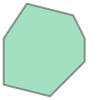

In [68]:
pol3.convex_hull

(shapely-boolean-functions)=
## Boolean functions

`shapely` includes the standard geometric functions to evaluate *relations* between geometries. These are defined as methods of one geometry, whereas the argument is another geometry ({numref}`shapely-boolean-methods`).

```{table} <code>shapely</code> boolean methods
:name: shapely-boolean-methods

| Method | Meaning |
|---|---|
| [`.equals`](https://shapely.readthedocs.io/en/stable/manual.html#object.equals) | Equals |
| [`.almost_equals`](https://shapely.readthedocs.io/en/stable/manual.html#object.almost_equals) | Approximately equal |
| [`.contains`](https://shapely.readthedocs.io/en/stable/manual.html#object.contains) | Contains |
| [`.covers`](https://shapely.readthedocs.io/en/stable/manual.html#object.covers) | Covers |
| [`.covered_by`](https://shapely.readthedocs.io/en/stable/manual.html#object.covered_by) | Covered by |
| [`.crosses`](https://shapely.readthedocs.io/en/stable/manual.html#object.crosses) | Crosses |
| [`.disjoint`](https://shapely.readthedocs.io/en/stable/manual.html#object.disjoint) | Disjoint |
| [`.intersects`](https://shapely.readthedocs.io/en/stable/manual.html#object.intersects) | Intersects |
| [`.overlaps`](https://shapely.readthedocs.io/en/stable/manual.html#object.overlaps) | Overlaps |
| [`.touches`](https://shapely.readthedocs.io/en/stable/manual.html#object.touches) | Touches |
| [`.within`](https://shapely.readthedocs.io/en/stable/manual.html#object.within) | Within |
```

For example, the [`.intersects`](https://shapely.readthedocs.io/en/stable/manual.html#object.intersects) method evaluates whether one geometry intersects with another. Here, we examine whether `pol1` intersects with `pol3`:

In [69]:
pol1.intersects(pol3)

False

The answer is `False`, meaning that the two geometries *do not* intersect, as evident in the following figure:

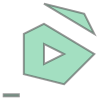

In [70]:
shapely.geometry.GeometryCollection([pol1, pol3])

However, `pol1` *does* intersect with `pol2`:

In [71]:
pol1.intersects(pol2)

True

as demonstrated below:

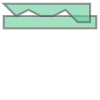

In [72]:
shapely.geometry.GeometryCollection([pol1, pol2])

The `.intersects` method is probably the most useful one, since we are usually interested in simply finding out whether the given two geometries intersect or not. There are other functions referring to more specific relations, such as [`.equals`](https://shapely.readthedocs.io/en/stable/manual.html#object.equals), [`.contains`](https://shapely.readthedocs.io/en/stable/manual.html#object.contains), [`.crosses`](https://shapely.readthedocs.io/en/stable/manual.html#object.crosses), and [`.touches`](https://shapely.readthedocs.io/en/stable/manual.html#object.touches) ({numref}`shapely-boolean-methods`). 

```{note}
See the [Binary Predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates) section in the `shapely` documentation for a complete list and more details on boolean functions for evaluating geometry relations.
```

(shapely-new-geometries-2)=
## New geometries 2

### Overview

Earlier, we dealt with methods to create a new geometry given an individual input geometry, such as calculating a centroid, a buffer, or a convex hull (see {ref}`shapely-new-geometries-1`). `shapely` also defines the standard methods to create an new geometry based on a *pair* of input geometries, which is what we cover in this section ({ref}`shapely-new-geoms-pair`).

```{table} <code>shapely</code> functions to create a new geometry from an input pair of geometries
:name: shapely-new-geoms-pair

| Method | Meaning |
|---|---|
| [`.intersection`](https://shapely.readthedocs.io/en/stable/manual.html#object.intersection) | {ref}`shapely-intersection` |
| [`.union`](https://shapely.readthedocs.io/en/stable/manual.html#object.union) | {ref}`shapely-union` |
| [`.difference`](https://shapely.readthedocs.io/en/stable/manual.html#object.difference) | {ref}`shapely-difference` |
| [`.symmetric_difference`](https://shapely.readthedocs.io/en/stable/manual.html#object.symmetric_difference) | Symmetric difference |
```

For example, given two partially overlapping circles, `x` (left) and `y` (right): 

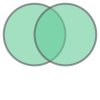

In [73]:
x = shapely.geometry.Point((0, 0)).buffer(1)
y = shapely.geometry.Point((1, 0)).buffer(1)
shapely.geometry.GeometryCollection([x, y])

Here is the intersection:

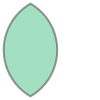

In [74]:
x.intersection(y)

Here is the difference of `x` from `y`:

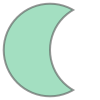

In [75]:
x.difference(y)

And here is the union:

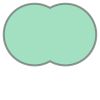

In [76]:
x.union(y)

In the next three sub-sections we elaborate on each of those methods.

```{note}
Another function of the same "group", which we do not cover here, is `.symmetric_difference`. See the documentation: <https://shapely.readthedocs.io/en/stable/manual.html#object.symmetric_difference>.
```

(shapely-intersection)=
### Intersection

The *intersection* of two geometries is defined, in plain terms, as their shared area. Given two geometries `x` and `y`, the intersection is given by the [`.intersection`](https://shapely.readthedocs.io/en/stable/manual.html#object.intersection) method, as in `x.intersection(y)`. Note that, since the intersection operator is *symmetric*, `y.intersection(x)` gives the same result.

As an example, let us calculate the area of intersection of `pol1` and `pol2`:

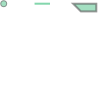

In [77]:
pol1.intersection(pol2)

These two polygons were intentionally [^intersection_geometrycollection] constructed in such a way that their intersection results in three parts: a `"Point"`, a `"LineString"`, and a `"Polygon"`. Since the result must still be contained in a single geometry object, this must be a `"GeometryCollection"` ({numref}`geometry-types-wkt-examples`):

[^intersection_geometrycollection]: The polygon coordinates are from an example in the `sf` R package documentation: <https://cran.r-project.org/web/packages/sf/vignettes/sf1.html>.

In [78]:
print(pol1.intersection(pol2))

GEOMETRYCOLLECTION (POLYGON ((7 0, 7 -0.5, 6 -0.5, 5.5 0, 7 0)), LINESTRING (4 0, 3 0), POINT (1 0))


Note that the intersection of two geometries may be an *empty* geometry, in case the geometries do not have even one point in common:

In [79]:
print(pol1.intersection(pol3))

POLYGON EMPTY


(shapely-union)=
### Union

The [`.union`](https://shapely.readthedocs.io/en/stable/manual.html#object.union) method, as in `x.union(y)`, returns the area of covered by at least one of the geometries `x` and `y` (or both). For example, recall `pol1` and `pol2`:

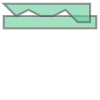

In [80]:
shapely.geometry.GeometryCollection([pol1, pol2])

Here is their union:

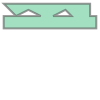

In [81]:
pol1.union(pol2)

Like `.intersection` (see {ref}`shapely-intersection`), the `.union` operation is *symmetric*. For example, `pol2.union(pol1)` gives the same result as above:

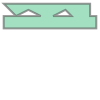

In [82]:
pol2.union(pol1)

(shapely-difference)=
### Difference

The third commonly used pairwise operator to create a new geometry is the [`.difference`](https://shapely.readthedocs.io/en/stable/manual.html#object.difference) method. The operation `x.difference(y)` returns the area of `x` *minus* the area of `y`. For example:

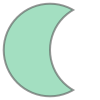

In [83]:
x.difference(y)  # The area of 'x' minus the area of 'y'

Unlike `.intersection` and `.union`, the `.difference` method is asymmetric. Namely, `y.difference(x)` is not the same as `x.difference(y)`:

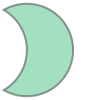

In [84]:
y.difference(x)  # The area of 'y' minus the area of 'x'

```{admonition} Exercise 07-f
:class: important
* Calculate the difference between the bounding box of `pol3`, and `pol3` ({numref}`exercise-07-f1`).
* Create a polygon where the `pol1` rectangular polygon comprises a polygon hole. To do that, apply a buffer on `pol1`, then "erase" the the original `pol1` from the buffered one using `.difference` ({numref}`exercise-07-f2`). 
```

```{glue:figure} exercise-07-f1
---
name: exercise-07-f1
---
Solution of exercise-07-f: Difference between bounding box of `pol3` and self 
```

```{glue:figure} exercise-07-f2
---
name: exercise-07-f2
---
Solution of exercise-07-f: A polygon where the `pol1` comprises a hole
```

(shapely-distance)=
## Distance (`shapely`)

Another very common operation in spatial analysis is the calculation of *distance*. As part of our analysis we often need to figure out how far are the given geometries from each other. For example, we may need to calculate what is the distance of a particular city from a source of air pollution such as a power plants, and so on.

In `shapely`, the distance between two geometries `x` and `y` is calculated using the [`.distance`](https://shapely.readthedocs.io/en/stable/manual.html#object.distance) method, as in `x.distance(y)`. For example, the following expression returns the distance between `pol1` and `pol3`:

In [85]:
pol1.distance(pol3)

10.307764064044152

```{admonition} Exercise 07-g
:class: important
* Do you think the `.distance` operator is *symmetric*? 
* Execute the reverse `pol3.distance(pol1)` to check your answer.
```

Keep in mind that distance is defnied as "shortest" distance, i.e., the minimal distance between any pair of points on the two geometries.

As can be expected, the distance between two geometries that *intersect* is zero. For example:

In [86]:
pol1.distance(pol2)

0.0

(shapely-geometry-casting)=
## Points to line (`shapely`)

Geometry transformations, sometimes called "geometry casting", are operations where we convert a geometry from one type to another. Not all combinations make sense, and not all are useful. For example, there is no sensible way to transform a `"Point"` to a `"Polygon"`, because a valid polygon needs to be composed of at least three coordinates (a triangle). A `"Polygon"`, however, can always be transformed to a `"MultiPoint"`, which represents the the polygon coordinates as separate points.

One of the most useful geometry casting operations, which we will come back to later on in the book (see {ref}`geopandas-points-to-line`) is the transformation of a `"MultiPoint"` geometry, or a set of `"Point"` geometries, to a `"LineString"` geometry which "connects" the points according to their given order. For example, a series of chronologically ordered GPS readings, may be connected to a `"LineString"` representing the recorded *route*. This type of casting facilitates further analysis, such as visualizing the route, calculating its total length, figuring out which areas the route goes through, and so on.

We have already seen that the `shapely.geometry.LineString` function accepts a `list` of coordinates ({ref}`shapely-create-specific-functions`). Alternatively, the `shapely.geometry.LineString` function can accept `list` of `"Point"` geometries, and "transform" it into a `"LineString"`. To demonstrate, let us create five `"Point"` geometries named `p1`, `p2`, `p3`, `p4`, and `p5`, using `wkt.loads` ({ref}`shapely-from-wkt`):

In [87]:
p1 = shapely.wkt.loads("POINT (0 0)")
p2 = shapely.wkt.loads("POINT (1 1)")
p3 = shapely.wkt.loads("POINT (2 -1)")
p4 = shapely.wkt.loads("POINT (2.5 2)")
p5 = shapely.wkt.loads("POINT (1 -1)")

Next, we combine the geometries into a `list` named `p`:

In [88]:
p = [p1, p2, p3, p4, p5]
p

Now we can use the `shapely.geometry.LineString` function to transform the `list` of point geometries to a `"LineString"` geometry:

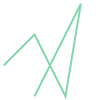

In [89]:
shapely.geometry.LineString(p)

We will come back to this technque for a more realistic example (see {ref}`geopandas-points-to-line`), where we are going to calculate a `"LineString"` geometryies of public transport routes based on the GTFS dataset (see {ref}`what-is-gtfs`).

(exercise-shapely)=
## More exercises

```{admonition} Exercise 07-h
:class: important
* Create two geometries—a square and a circle—in such a way that they partially overlap, so that $1\over4$ of the circle area overlaps with the square ({numref}`exercise-07-h0`). Hint: use the buffer function applied on a point geometry to create the circle.
* Calculate and plot the geometry representing the *union* of the square and the circle ({numref}`exercise-07-h1`).
* Calculate and plot the geometry representing the *intersection* of the square and the circle ({numref}`exercise-07-h2`). 
* Calculate the *area* of the intersection and of the the union geometries. 
```

```{glue:figure} exercise-07-h0
---
name: exercise-07-h0
---
Solution of exercise-07-h: Overlapping square and circle
```

```{glue:figure} exercise-07-h1
---
name: exercise-07-h1
---
Solution of exercise-07-h: Union of square and circle
```

```{glue:figure} exercise-07-h2
---
name: exercise-07-h2
---
Solution of exercise-07-h2: Intersection of square and circle
```

```{admonition} Exercise 07-i
:class: important
* Execute the code section given below to get a `DataFrame` with the location of bus stops along bus line 24 in Beer-Sheva, the route which goes from Ramot to Beer-Sheva Central Bus Station. The bus stop coordinates are in the `"stop_lon"` and `"stop_lat"` columns.
* Calculate and plot a `MultiPoint` geometry with all stop locations ({numref}`exercise-07-i_stops_pnt`). Hint: extract the contents of the `"stop_lon"` and `"stop_lat"` columns as a list of lists/tuples, then use appropriate function to create a `MulpiPoint` geometry (see {ref}`shapely-create-specific-functions`).
* Calculate and plot a `LineString` geometry with of the bus route ({numref}`exercise-07-i_stops_line`).
* Calculate and plot a `LineString` geometry with the straight line between the *first* and *last* bus stops ({numref}`exercise-07-i_stops_line1`).
* Calculate and plot the convex hull polygon (see {ref}`convex-hull`) of the bus stops ({numref}`exercise-07-i_ch`).

```py
import pandas as pd
stops = pd.read_csv("data/gtfs/stops.txt")
stop_times = pd.read_csv("data/gtfs/stop_times.txt")
stops = stops[["stop_id", "stop_name", "stop_lon", "stop_lat"]]
stop_times = stop_times[["trip_id", "stop_id", "stop_sequence"]]
sel = stop_times["trip_id"] == "55745843_180421"
stop_times = stop_times[sel]
stops = pd.merge(stop_times, stops, on="stop_id", how="left")
stops = stops.sort_values(by="stop_sequence")
```

```{glue:figure} exercise-07-i_stops_pnt
---
name: exercise-07-i_stops_pnt
---
Solution of exercise-07-i: bus stops as points
```

```{glue:figure} exercise-07-i_stops_line
---
name: exercise-07-i_stops_line
---
Solution of exercise-07-i: bus stops as line
```

```{glue:figure} exercise-07-i_stops_line1
---
name: exercise-07-i_stops_line1
---
Solution of exercise-07-i: straight line from first bus stop to last
```

```{glue:figure} exercise-07-i_ch
---
name: exercise-07-i_ch
---
Solution of exercise-07-i: Convex Hull of bus stops
```